# Prediction with Machine Learning for Economists - Assignment 2

Done by: Yu Xu
    
Date: 09 February 2023

In [1]:
import pandas as pd
import numpy as np
import os
import re
from pathlib import Path
import sys
import math
from patsy import dmatrices
from datetime import datetime
from sklearn.model_selection import train_test_split
from mizani.formatters import percent_format
from plotnine import *
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

## Part 1: Clean Raw Data

### Import and clean raw data

In [2]:
data = pd.read_csv("listings.csv", delimiter=",", dtype="unicode")

### Chose small and mid-size apartments hosting 2-6 guests

In [3]:
data["accommodates"] = data["accommodates"].astype(int)
data = data[(data['accommodates'] <= 6) & (data['accommodates'] >= 2)]

In [4]:
data = data[data['room_type'] == 'Entire home/apt']

In [5]:
data = data.loc[lambda x: x['property_type'].isin(['Entire rental unit',
                                                   'Entire condominium (condo)',
                                                   'Entire loft',
                                                   'Entire serviced apartment'])]

In [6]:
data["property_type"].value_counts()

Entire rental unit            6984
Entire loft                   1519
Entire condominium (condo)    1510
Entire serviced apartment     1281
Name: property_type, dtype: int64

### Data processing

In [7]:
# drop some useless variables
drops = [
    "host_thumbnail_url",
    "host_picture_url",
    "listing_url",
    "picture_url",
    "host_url",
    "last_scraped",
    "description",
    "neighborhood_overview",
    "host_about",
    "host_response_time",
    "name",
    "host_location",
]
data.drop(columns=drops, inplace=True)

In [8]:
# drop broken lines - where id is not a character of numbers
data.id = pd.to_numeric(data.id, errors="coerce")
data = data[data.id.notna()]

In [9]:
# formatting columns
for perc in ["host_response_rate", "host_acceptance_rate"]:
    data[perc] = pd.to_numeric(data[perc], errors="coerce")

In [10]:
# format binary variables
for binary in [
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "instant_bookable",
]:
    data[binary] = data[binary].map({"t": True, "f": False})

Deal with **amenities** variable and generate corresponding dummy variables.

In [11]:
data["amenities"] = data["amenities"].str.strip("[]").str.replace('"', "").str.replace(' ','').str.split(",")

In [12]:
def filter_amenities(amenities_list):
    return [amenity for amenity in amenities_list if "\\" not in amenity]

data["amenities"] = data["amenities"].apply(filter_amenities)

Keep the top 70 amenities in terms of quantity to avoid being affected by extreme values of some amenities.

In [13]:
amenities_data = data["amenities"].apply(pd.Series).stack().reset_index(level=1, drop=True).to_frame("amenity")
amenities_data["count"] = 1
amenities_data = amenities_data.groupby("amenity").sum().reset_index()
amenities_data = amenities_data.sort_values("count", ascending=False)
top_70_amenities = amenities_data[:70]
top_70_amenities

,amenity,count
2,Airconditioning,11052
109,Longtermstaysallowed,11000
183,Wifi,10905
88,Hairdryer,10185
181,Washer,10093
...,...,...
58,Dishwasher,331
12,Bathtub,316
182,Waterfront,305
179,Tablecornerguards,257


In [14]:
# generate 70 dummy variables for amenities and corporate them into the main dataset
top_70_amenities_list = list(top_70_amenities["amenity"])

def get_amenities(row):
    amenities = {}
    for amenity in top_70_amenities_list:
        amenities[amenity] = 1 if amenity in row["amenities"] else 0
    return pd.Series(amenities)

amenities_data = data.apply(get_amenities, axis=1)
amenities_data

,Airconditioning,Longtermstaysallowed,Wifi,Hairdryer,Washer,Shampoo,Essentials,Hangers,Hotwater,Kitchen,...,Indoorfireplace,Coffeemaker,Pool,Singlelevelhome,Hostgreetsyou,Dishwasher,Bathtub,Waterfront,Tablecornerguards,Outletcovers
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,...,0,1,0,0,0,0,0,0,0,0
5,1,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
10,1,1,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29417,1,1,1,1,1,1,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
29418,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
29419,1,1,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
29420,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [15]:
data = pd.concat([data, amenities_data], axis=1)

In [16]:
data

,id,scrape_id,host_id,host_name,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,...,Indoorfireplace,Coffeemaker,Pool,Singlelevelhome,Hostgreetsyou,Dishwasher,Bathtub,Waterfront,Tablecornerguards,Outletcovers
1,34330858,20220326120824,259183941,建华,2019-05-01,NaN,NaN,True,Jiading,2,...,0,0,0,0,0,0,0,0,0,0
2,24963,20220326120824,98203,Jia,2010-03-24,NaN,NaN,True,Conservatory,2,...,0,1,0,0,0,0,0,0,0,0
5,479517,20220326120824,681552,Leon,2011-06-09,NaN,NaN,True,Putuo,4,...,0,0,0,0,0,0,0,0,0,0
6,479530,20220326120824,681552,Leon,2011-06-09,NaN,NaN,True,Putuo,4,...,0,0,0,0,0,0,0,0,0,0
10,20614648,20220326120824,25383210,列飞,2014-12-30,NaN,NaN,True,Jiading,11,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29417,54310450,20220326120824,224456459,周,2018-11-06,NaN,NaN,False,Jiading,13,...,0,0,0,0,0,1,0,0,0,0
29418,49472335,20220326120824,345507383,认证手机用户2637,2020-05-06,NaN,NaN,False,NaN,0,...,0,0,0,0,0,0,0,0,0,0
29419,46587231,20220326120824,374618280,山里,2020-11-06,NaN,NaN,False,NaN,3,...,0,0,0,0,0,0,0,0,0,0
29420,16329141,20220326120824,76569399,一朵小宿,2016-06-08,NaN,NaN,False,Jiading,7,...,0,0,0,0,0,0,0,0,0,0


Deal with **bathrooms** variable: extract the number in the **bathrooms_text** into **bathrooms**.

In [17]:
def extract_bathrooms(row):
    bathroom_text = row["bathrooms_text"]
    if type(bathroom_text) == float:
        return bathroom_text
    elif bathroom_text == "Half-bath":
        return 0.5
    else:
        try:
            return float(bathroom_text.split(" ")[0])
        except ValueError:
            # handle cases where the value is not a number
            return None

data["bathrooms"] = data.apply(extract_bathrooms, axis=1)

In [18]:
# write csv
data.to_csv("airbnb_shanghai_cleaned.csv", index=False)

## Part 2: Data Processing for Analysis

### Import clean data

In [19]:
data = pd.read_csv("airbnb_shanghai_cleaned.csv", delimiter=",", dtype="unicode")

### Create categorical variables

In [20]:
# property_type
data["f_property_type"] = data["property_type"].astype("category")

In [21]:
# neighbourhood_cleansed
data["f_neighbourhood_cleansed"] = data["neighbourhood_cleansed"].astype("category")

### Create numerical variables

In [22]:
# add new numeric columns from certain columns

numericals = [
    "accommodates",
    "bathrooms",
    "review_scores_rating",
    "number_of_reviews",
    "reviews_per_month",
    "minimum_nights",
    "beds",
]

for col in numericals:
    data["n_" + col] = pd.to_numeric(data[col], errors="coerce")

In [23]:
# create days since first review

data["n_days_since"] = (
    data.calendar_last_scraped.apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
    - data.first_review.fillna("1950-01-01").apply(
        lambda x: datetime.strptime(x, "%Y-%m-%d")
    )
).dt.days

data["n_days_since"] = np.where(data.first_review.isnull(), np.nan, data.n_days_since)

In [24]:
# create dummy variables
dummies = data.columns[62:132]

for col in dummies:
    data["d_" + (re.sub("/|\s|-", "", col)).replace("(s)", "s").lower()] = data[col]

In [25]:
# keep columns if contain d_, n_,f_, p_, usd_ and some others
data = pd.concat(
    [
        data.filter(
            regex="^d_.*|^n_.*|^f_.*|^p_.*|^usd_.*",
        ),
        data[
            [
                "price",
                "id",
                "neighbourhood_cleansed",
                "property_type",
            ]
        ],
    ],
    axis=1,
)

In [26]:
# price
data["price"] = data["price"].str.replace("$", "").str.replace(",", "").astype(float)

### Create more variables

In [27]:
# Squares and further values to create
data = data.assign(
    n_accommodates2=lambda x: x["n_accommodates"] ** 2,
    ln_accommodates=lambda x: np.log(x["n_accommodates"]),
    ln_accommodates2=lambda x: np.log(x["n_accommodates"]) ** 2,
    ln_beds=lambda x: np.log(x["n_beds"]),
    ln_number_of_reviews=lambda x: np.log(x["n_number_of_reviews"] + 1),
)

In [28]:
# Pool accomodations with 0,1,2,15 bathrooms
bins = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 15)], closed="left")
f_bath = pd.cut(data["n_bathrooms"].to_list(), bins, labels=["0", "1", "2"])
f_bath.categories = [0, 1, 2]
data["f_bathroom"] = f_bath

f_bath.value_counts(dropna=False)

0        138
1      10323
2        824
NaN        9
dtype: int64

In [29]:
# Pool num of reviews to 3 categories: none, 1-51 and >51
bins = pd.IntervalIndex.from_tuples(
    [(0, 1), (1, 51), (51, max(data.n_number_of_reviews))], closed="left"
)
fnor = pd.cut(data["n_number_of_reviews"].to_list(), bins, labels=["0", "1", "2"])
fnor.categories = [0, 1, 2]
data["f_number_of_reviews"] = fnor
data["f_number_of_reviews"].value_counts(dropna=False)

1      6308
0      4118
2       867
NaN       1
Name: f_number_of_reviews, dtype: int64

In [30]:
# Pool and categorize the number of minimum nights: 1,2,3, 3+
bins = pd.IntervalIndex.from_tuples(
    [(1, 2), (2, 3), (3, max(data.n_minimum_nights))], closed="left"
)
f_min_n = pd.cut(data["n_minimum_nights"].to_list(), bins, labels=["1", "2", "3"])
f_min_n.categories = [1, 2, 3]
data["f_minimum_nights"] = f_min_n
data["f_minimum_nights"].value_counts(dropna=False)

1      8714
3      2128
2       451
NaN       1
Name: f_minimum_nights, dtype: int64

### Dealing with missing values

In [31]:
# Change Infinite values with NaNs
data = data.replace([np.inf, -np.inf], np.nan)

In [32]:
# where do we have missing variables now?
to_filter = data.isna().sum()
to_filter[to_filter > 0]

n_bathrooms                  8
n_review_scores_rating    4118
n_reviews_per_month       4118
n_beds                      89
n_days_since              4118
ln_beds                     89
f_bathroom                   9
f_number_of_reviews          1
f_minimum_nights             1
dtype: int64

In [33]:
# 1. drop if no target
data = data.loc[lambda x: x.price.notnull()]

In [34]:
# 2. imput when few, not that important
data = data.assign(
    n_bathrooms=lambda x: x["n_bathrooms"].fillna(np.median(x["n_bathrooms"].dropna())),
    n_beds=lambda x: np.where(x["n_beds"].isnull(), x["n_accommodates"], x["n_beds"]),
    f_bathroom=lambda x: x["f_bathroom"].fillna(1),
    f_minimum_nights=lambda x: x["f_minimum_nights"].fillna(1),
    f_number_of_reviews=lambda x: x["f_number_of_reviews"].fillna(1),
    ln_beds=lambda x: x["ln_beds"].fillna(0),
)

In [35]:
to_filter = data.isna().sum()
to_filter[to_filter > 0]

n_review_scores_rating    4118
n_reviews_per_month       4118
n_days_since              4118
dtype: int64

In [36]:
# 3. Replace missing variables re reviews with zero, when no review + add flags
data = data.assign(
    flag_days_since=np.multiply(data.n_days_since.isna(), 1),
    n_days_since=data.n_days_since.fillna(np.median(data.n_days_since.dropna())),
    flag_review_scores_rating=np.multiply(data.n_review_scores_rating.isna(), 1),
    n_review_scores_rating=data.n_review_scores_rating.fillna(
        np.median(data.n_review_scores_rating.dropna())
    ),
    flag_reviews_per_month=np.multiply(data.n_reviews_per_month.isna(), 1),
    n_reviews_per_month=data.n_reviews_per_month.fillna(
        np.median(data.n_reviews_per_month.dropna())
    ),
    flag_n_number_of_reviews=np.multiply(data.n_number_of_reviews.isna(), 1),
)

In [37]:
data.flag_days_since.value_counts()

0    7176
1    4118
Name: flag_days_since, dtype: int64

In [38]:
# redo features
# Create variables, measuring the time since: squared, cubic, logs
data = data.assign(
    ln_days_since=lambda x: np.log(x["n_days_since"] + 1),
    ln_days_since2=lambda x: np.log(x["n_days_since"] + 1) ** 2,
    ln_days_since3=lambda x: np.log(x["n_days_since"] + 1) ** 3,
    n_days_since2=lambda x: x["n_days_since"] ** 2,
    n_days_since3=lambda x: x["n_days_since"] ** 3,
    ln_review_scores_rating=lambda x: np.log(x["n_review_scores_rating"]),
)

In [39]:
data.ln_days_since = data["ln_days_since"].fillna(0)
data.ln_days_since2 = data["ln_days_since2"].fillna(0)
data.ln_days_since3 = data["ln_days_since3"].fillna(0)

In [40]:
to_filter = data.isna().sum()
to_filter[to_filter > 0]

Series([], dtype: int64)

In [41]:
data.describe()

,n_accommodates,n_bathrooms,n_review_scores_rating,n_number_of_reviews,n_reviews_per_month,n_minimum_nights,n_beds,n_days_since,price,n_accommodates2,...,flag_days_since,flag_review_scores_rating,flag_reviews_per_month,flag_n_number_of_reviews,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating
count,11294.000000,11294.000000,11294.000000,11294.000000,11294.000000,11294.000000,11294.000000,11294.000000,11294.000000,11294.000000,...,11294.000000,11294.000000,11294.000000,11294.0,11294.000000,11294.000000,11294.000000,1.129400e+04,1.129400e+04,1.129400e+04
mean,3.014432,1.130069,4.702275,14.215778,0.689430,11.022313,1.615460,734.418806,637.376660,10.783513,...,0.364618,0.364618,0.364618,0.0,6.401748,41.523221,272.078879,7.103635e+05,8.607870e+08,-inf
std,1.302636,0.366020,0.732087,33.077785,0.839275,42.397413,0.784995,413.530676,2417.310917,9.643902,...,0.481344,0.481344,0.481344,0.0,0.735450,8.572833,77.941535,8.816799e+05,1.998969e+09,NaN
min,2.000000,0.000000,0.000000,0.000000,0.010000,1.000000,1.000000,4.000000,0.000000,4.000000,...,0.000000,0.000000,0.000000,0.0,1.609438,2.590290,4.168912,1.600000e+01,6.400000e+01,-inf
25%,2.000000,1.000000,4.800000,0.000000,0.310000,1.000000,1.000000,537.000000,259.000000,4.000000,...,0.000000,0.000000,0.000000,0.0,6.287859,39.537165,248.604103,2.883690e+05,1.548542e+08,1.568616e+00
50%,2.000000,1.000000,4.880000,2.000000,0.450000,1.000000,1.000000,680.000000,370.000000,4.000000,...,0.000000,0.000000,0.000000,0.0,6.523562,42.556865,277.622361,4.624000e+05,3.144320e+08,1.585145e+00
75%,4.000000,1.000000,4.960000,12.000000,0.640000,1.000000,2.000000,900.000000,538.000000,16.000000,...,1.000000,1.000000,1.000000,0.0,6.803505,46.287684,314.918500,8.100000e+05,7.290000e+08,1.601406e+00
max,6.000000,15.000000,5.000000,453.000000,10.910000,1000.000000,7.000000,4200.000000,75771.000000,36.000000,...,1.000000,1.000000,1.000000,0.0,8.343078,69.606948,580.736191,1.764000e+07,7.408800e+10,1.609438e+00


In [42]:
# write csv
data.to_csv("airbnb_shanghai_workfile_adj.csv", index=False)

## Part 3: Models Selection and Comparison

### Split train and test data

- train is where we do it all, including Cross Validation 

- first pick a smaller than usual training set so that models run faster and check if works
- if works, start anew without these two lines

In [43]:
data_train, data_holdout = train_test_split( data, train_size=0.7, random_state=42)

In [44]:
data_train.shape, data_holdout.shape

((7905, 102), (3389, 102))

### Predictors selection based on domain knowledge

In [45]:
# basic variables inc neighbourhood
basic_vars = [
    "n_accommodates",
    "n_beds",
    "n_days_since",
    "f_property_type",
    "f_bathroom",
    "f_neighbourhood_cleansed",
]

# reviews
reviews = [
    "n_number_of_reviews",
    "flag_n_number_of_reviews",
    "n_review_scores_rating",
    "flag_review_scores_rating",
]

# dummy variables
amenities = [col for col in data if col.startswith("d_")]

# interactions for the LASSO
# from ch14
X1 = [
    "n_accommodates:f_property_type",
    "d_wifi:f_property_type",
    "f_property_type:d_freeparkingonpremises",
    "d_airconditioning:f_property_type",
    "d_longtermstaysallowed:f_property_type",
    "d_kitchen:f_property_type",
    "d_gym:f_property_type",
    "d_breakfast:f_property_type",
]
# with boroughs
X2 = [
    "f_property_type:f_neighbourhood_cleansed",
    "n_number_of_reviews:f_neighbourhood_cleansed",
    "n_accommodates:f_neighbourhood_cleansed",
]

In [46]:
predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + amenities
predictors_E = basic_vars + reviews + amenities + X1 + X2

### Models selection

1. ***OLS with dummies for area***

In [47]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

ols_model = LinearRegression().fit(X,y)

y_hat = ols_model.predict(X)

ols_rmse = mean_squared_error(y,y_hat,squared=False)
ols_rmse

2316.540192476344

In [48]:
ols_model_coeffs_df = pd.DataFrame(
    ols_model.coef_.tolist()[0],
    index=X.design_info.column_names,
    columns=["ols_coefficient"],
).assign(ols_coefficient=lambda x: x.ols_coefficient.round(3))
ols_model_coeffs_df

,ols_coefficient
Intercept,0.000
f_property_type[T.Entire loft],-38.452
f_property_type[T.Entire rental unit],40.495
f_property_type[T.Entire serviced apartment],56.707
f_bathroom[T.1],-190.367
...,...
n_days_since,0.134
n_number_of_reviews,-1.025
flag_n_number_of_reviews,-0.000
n_review_scores_rating,44.243


2.  ***LASSO***

The parameter `l1_ratio7` corresponds to *alpha* in the `glmnet` R package while `alpha` corresponds to the *lambda* parameter in glmnet. Specifically, l1_ratio = 1 is the lasso penalty. 

In [49]:
lasso_model =  ElasticNet(l1_ratio = 1,normalize=True,fit_intercept=True)

In [50]:
lasso_model_cv = GridSearchCV(
    lasso_model,
    {"alpha":[i/100 for i in range(1, 50, 1)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

Use extended model with a series of interactions.

In [51]:
y, X = dmatrices("price ~ " + " + ".join(predictors_E), data_train)

In [52]:
%%time
lasso_model_cv.fit(X, y.ravel())

Fitting 5 folds for each of 49 candidates, totalling 245 fits
[CV 1/5] END ....................alpha=0.01;, score=-2183.945 total time=   1.2s
[CV 2/5] END ....................alpha=0.01;, score=-3304.522 total time=   0.6s
[CV 3/5] END ....................alpha=0.01;, score=-2217.945 total time=   0.6s
[CV 4/5] END ....................alpha=0.01;, score=-1989.635 total time=   0.8s
[CV 5/5] END ....................alpha=0.01;, score=-1963.639 total time=   0.5s
[CV 1/5] END ....................alpha=0.02;, score=-2178.590 total time=   0.4s
[CV 2/5] END ....................alpha=0.02;, score=-3303.120 total time=   0.6s
[CV 3/5] END ....................alpha=0.02;, score=-2217.235 total time=   0.5s
[CV 4/5] END ....................alpha=0.02;, score=-1987.104 total time=   0.5s
[CV 5/5] END ....................alpha=0.02;, score=-1961.286 total time=   0.3s
[CV 1/5] END ....................alpha=0.03;, score=-2174.335 total time=   0.2s
[CV 2/5] END ....................alpha=0.03;, s

[CV 4/5] END ....................alpha=0.21;, score=-1966.316 total time=   0.2s
[CV 5/5] END ....................alpha=0.21;, score=-1942.521 total time=   0.0s
[CV 1/5] END ....................alpha=0.22;, score=-2153.129 total time=   0.0s
[CV 2/5] END ....................alpha=0.22;, score=-3293.532 total time=   0.0s
[CV 3/5] END ....................alpha=0.22;, score=-2201.535 total time=   0.0s
[CV 4/5] END ....................alpha=0.22;, score=-1965.181 total time=   0.1s
[CV 5/5] END ....................alpha=0.22;, score=-1942.332 total time=   0.0s
[CV 1/5] END ....................alpha=0.23;, score=-2152.991 total time=   0.0s
[CV 2/5] END ....................alpha=0.23;, score=-3293.516 total time=   0.0s
[CV 3/5] END ....................alpha=0.23;, score=-2200.967 total time=   0.1s
[CV 4/5] END ....................alpha=0.23;, score=-1964.453 total time=   0.1s
[CV 5/5] END ....................alpha=0.23;, score=-1942.082 total time=   0.0s
[CV 1/5] END ...............

[CV 3/5] END ....................alpha=0.43;, score=-2190.915 total time=   0.0s
[CV 4/5] END ....................alpha=0.43;, score=-1955.054 total time=   0.0s
[CV 5/5] END ....................alpha=0.43;, score=-1937.968 total time=   0.0s
[CV 1/5] END ....................alpha=0.44;, score=-2151.434 total time=   0.0s
[CV 2/5] END ....................alpha=0.44;, score=-3292.075 total time=   0.0s
[CV 3/5] END ....................alpha=0.44;, score=-2190.483 total time=   0.0s
[CV 4/5] END ....................alpha=0.44;, score=-1954.795 total time=   0.0s
[CV 5/5] END ....................alpha=0.44;, score=-1937.851 total time=   0.0s
[CV 1/5] END ....................alpha=0.45;, score=-2151.509 total time=   0.0s
[CV 2/5] END ....................alpha=0.45;, score=-3292.022 total time=   0.0s
[CV 3/5] END ....................alpha=0.45;, score=-2190.062 total time=   0.0s
[CV 4/5] END ....................alpha=0.45;, score=-1954.548 total time=   0.0s
[CV 5/5] END ...............

GridSearchCV(cv=5, estimator=ElasticNet(l1_ratio=1, normalize=True),
             param_grid={'alpha': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,
                                   0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14,
                                   0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21,
                                   0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28,
                                   0.29, 0.3, ...]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [53]:
pd.DataFrame(
    lasso_model_cv.best_estimator_.coef_.tolist(),
    index=X.design_info.column_names,
    columns=["lasso_coefficient"],
).assign(lasso_coefficient=lambda x: x.lasso_coefficient.round(3)).loc[
    lambda x: x.lasso_coefficient != 0
]

,lasso_coefficient
f_bathroom[T.1],-189.367
f_bathroom[T.2],139.155
f_neighbourhood_cleansed[T.松江区 / Songjiang District],-63.578
f_neighbourhood_cleansed[T.静安区 / Jing'an District],45.663
d_essentials[T.1],-167.814
d_smokealarm[T.1],-62.554
d_fireextinguisher[T.1],-12.903
d_heating[T.1],21.739
d_paidparkingoffpremises[T.1],-18.650
d_showergel[T.1],-27.129


In [54]:
lasso_model_cv.best_estimator_

ElasticNet(alpha=0.49, l1_ratio=1, normalize=True)

In [55]:
lasso_model_cv.cv_results_

{'mean_fit_time': array([0.75140014, 0.45141716, 0.36403461, 0.29685383, 0.26428218,
        0.22422562, 0.2010232 , 0.19900503, 0.17135992, 0.1801774 ,
        0.10357513, 0.09973907, 0.08523736, 0.09364824, 0.09117665,
        0.08457108, 0.07762718, 0.07411218, 0.06577187, 0.07097154,
        0.07107668, 0.05834541, 0.05758176, 0.05030756, 0.04497089,
        0.04293523, 0.04145517, 0.04713774, 0.03667741, 0.03909283,
        0.03624959, 0.03494482, 0.04365888, 0.0384891 , 0.0434958 ,
        0.03489246, 0.02727017, 0.02640748, 0.0281003 , 0.02428279,
        0.02222695, 0.02423544, 0.02851362, 0.02433405, 0.02426887,
        0.02298956, 0.02551274, 0.02138896, 0.02752681]),
 'std_fit_time': array([0.24709419, 0.11737265, 0.1284744 , 0.14244744, 0.1346318 ,
        0.11826131, 0.09533389, 0.11377803, 0.08119591, 0.09031804,
        0.08021493, 0.08995429, 0.08241864, 0.10024909, 0.09383736,
        0.08095487, 0.07624313, 0.07443461, 0.06498279, 0.06536436,
        0.06649588, 0.045

In [56]:
lasso_rmse = pd.DataFrame(lasso_model_cv.cv_results_).loc[
    lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha
].mean_test_score.values[0] * -1
lasso_rmse

2304.6782675267254

3. ***CART model***

In [57]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

In [58]:
cart_model = DecisionTreeRegressor(random_state=2023)

In [59]:
# Get potential ccp_alpha parameters
path = cart_model.cost_complexity_pruning_path(X, y.ravel())
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [60]:
ccp_alphas

array([     0.        ,      0.        ,      0.        , ...,
        84610.94317121, 142702.26431808, 190130.34797309])

In [61]:
ccp_alphas.shape

(6102,)

Apply random search to select a "best" alpha, default is 10 iterations
`RandomizedSearchCV` does not calculate all potential alphas, just a random 10-element subset of the many potential alphas.

In [62]:
%%time

cart_model_cv = RandomizedSearchCV(
    cart_model,
    {"ccp_alpha":ccp_alphas},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)
cart_model_cv.fit(X,y.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ...ccp_alpha=22.06536443799552;, score=-3006.040 total time=   0.1s
[CV 2/5] END ...ccp_alpha=22.06536443799552;, score=-3841.464 total time=   0.1s
[CV 3/5] END ...ccp_alpha=22.06536443799552;, score=-2928.164 total time=   0.1s
[CV 4/5] END ...ccp_alpha=22.06536443799552;, score=-3107.592 total time=   0.1s
[CV 5/5] END ...ccp_alpha=22.06536443799552;, score=-3013.080 total time=   0.1s
[CV 1/5] END .ccp_alpha=0.06377819945181515;, score=-3010.179 total time=   0.1s
[CV 2/5] END .ccp_alpha=0.06377819945181515;, score=-3845.123 total time=   0.1s
[CV 3/5] END .ccp_alpha=0.06377819945181515;, score=-2928.833 total time=   0.1s
[CV 4/5] END .ccp_alpha=0.06377819945181515;, score=-3109.240 total time=   0.1s
[CV 5/5] END .ccp_alpha=0.06377819945181515;, score=-3014.545 total time=   0.1s
[CV 1/5] END .ccp_alpha=0.02530044275774826;, score=-3010.205 total time=   0.1s
[CV 2/5] END .ccp_alpha=0.02530044275774826;, sc

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=2023),
                   param_distributions={'ccp_alpha': array([     0.        ,      0.        ,      0.        , ...,
        84610.94317121, 142702.26431808, 190130.34797309])},
                   scoring='neg_root_mean_squared_error', verbose=3)

In [63]:
cart_rmse = pd.DataFrame(cart_model_cv.cv_results_).loc[
    lambda x: x.param_ccp_alpha == cart_model_cv.best_estimator_.ccp_alpha
].mean_test_score.values[0] * -1
cart_rmse

3179.2679025921784

4. ***Random Forest***

`dmatrices()` constructs two design matrices given a formula_like and data. By convention, the first matrix is the “outcome” or “y” data, and the second is the “predictor” or “x” data.

In [64]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

In [65]:
X.shape

(7905, 98)

In [66]:
# using ravel() we flatten y to a one-dimensional data object. 
y.ravel().shape

(7905,)

In [67]:
rfr = RandomForestRegressor(random_state = 42)

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

A random forest needs a little tuning, i.e. three parameters: the number of bootstrap samples, the number of variables considered for each split, and the minimum number of observations in the terminal nodes of each tree as a stopping rule. For the number of bootstrap draws, I went with the default option of 500. For the number of variables, one rule of thumb is to pick the square root of the total number of variables, which would be around 10, so we tried 8, 10, and 12. For the minimum number of observations in the terminal nodes, we choose 5, 10, and 15.

In [68]:
tune_grid = {"max_features": [6, 8, 10, 12], "min_samples_leaf": [5, 10, 15]}

`GridsearchCV()` is an exhaustive search over specified parameter values for an estimator.

In [69]:
rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [70]:
%%time
rf_model = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_features=6, min_samples_leaf=5;, score=-2137.717 total time=   0.3s
[CV 2/5] END max_features=6, min_samples_leaf=5;, score=-3268.164 total time=   0.3s
[CV 3/5] END max_features=6, min_samples_leaf=5;, score=-2158.913 total time=   0.3s
[CV 4/5] END max_features=6, min_samples_leaf=5;, score=-1955.351 total time=   0.3s
[CV 5/5] END max_features=6, min_samples_leaf=5;, score=-1874.462 total time=   0.3s
[CV 1/5] END max_features=6, min_samples_leaf=10;, score=-2145.107 total time=   0.3s
[CV 2/5] END max_features=6, min_samples_leaf=10;, score=-3276.328 total time=   0.3s
[CV 3/5] END max_features=6, min_samples_leaf=10;, score=-2160.180 total time=   0.3s
[CV 4/5] END max_features=6, min_samples_leaf=10;, score=-1961.522 total time=   0.3s
[CV 5/5] END max_features=6, min_samples_leaf=10;, score=-1873.526 total time=   0.3s
[CV 1/5] END max_features=6, min_samples_leaf=15;, score=-2142.547 total time=   0.2

In [71]:
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]

df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']

df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

min node size,5,10,15
max features,,,
6,2278.92,2283.33,2280.62
8,2273.78,2277.18,2277.23
10,2275.00,2276.82,2277.39
12,2274.75,2275.25,2278.81


In [72]:
rf_model_rmse = rf_model.best_score_ * -1

RMSE is the smallest with max_features of 8 and min_samples_leaf of 5.

In [73]:
rf_model.best_params_

{'max_features': 8, 'min_samples_leaf': 5}

4. ***GBM***

In [74]:
gbm = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=20, max_features = 10, n_estimators = 50)

tune_grid = {"n_estimators": [i for i in range(100, 500, 50)], "max_depth": [1, 5, 10]}

gbm_model_cv = GridSearchCV(
    gbm,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
    n_jobs=-1
)

In [75]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)

In [76]:
%%time
gbm_pipe.fit(data_train[predictors_2],data_train.price)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 3/5; 1/24] START max_depth=1, n_estimators=100..............................
[CV 3/5; 1/24] END max_depth=1, n_estimators=100;, score=-2168.824 total time=   0.2s
[CV 5/5; 2/24] START max_depth=1, n_estimators=150..............................
[CV 5/5; 2/24] END max_depth=1, n_estimators=150;, score=-1877.924 total time=   0.2s
[CV 1/5; 4/24] START max_depth=1, n_estimators=250..............................
[CV 1/5; 4/24] END max_depth=1, n_estimators=250;, score=-2149.255 total time=   0.3s
[CV 4/5; 5/24] START max_depth=1, n_estimators=300..............................
[CV 4/5; 5/24] END max_depth=1, n_estimators=300;, score=-1959.101 total time=   0.4s
[CV 2/5; 7/24] START max_depth=1, n_estimators=400..............................
[CV 2/5; 7/24] END max_depth=1, n_estimators=400;, score=-3279.848 total time=   0.6s
[CV 5/5; 8/24] START max_depth=1

[CV 5/5; 1/24] START max_depth=1, n_estimators=100..............................
[CV 5/5; 1/24] END max_depth=1, n_estimators=100;, score=-1880.941 total time=   0.2s
[CV 3/5; 3/24] START max_depth=1, n_estimators=200..............................
[CV 3/5; 3/24] END max_depth=1, n_estimators=200;, score=-2174.029 total time=   0.3s
[CV 1/5; 5/24] START max_depth=1, n_estimators=300..............................
[CV 1/5; 5/24] END max_depth=1, n_estimators=300;, score=-2151.213 total time=   0.4s
[CV 4/5; 6/24] START max_depth=1, n_estimators=350..............................
[CV 4/5; 6/24] END max_depth=1, n_estimators=350;, score=-1961.181 total time=   0.5s
[CV 3/5; 8/24] START max_depth=1, n_estimators=450..............................
[CV 3/5; 8/24] END max_depth=1, n_estimators=450;, score=-2178.668 total time=   0.5s
[CV 1/5; 10/24] START max_depth=5, n_estimators=150.............................
[CV 1/5; 10/24] END max_depth=5, n_estimators=150;, score=-2194.014 total time=   0.

[CV 1/5; 16/24] START max_depth=5, n_estimators=450.............................
[CV 1/5; 16/24] END max_depth=5, n_estimators=450;, score=-2291.383 total time=   1.7s
[CV 4/5; 19/24] START max_depth=10, n_estimators=200............................
[CV 4/5; 19/24] END max_depth=10, n_estimators=200;, score=-2182.861 total time=   1.4s
[CV 1/5; 21/24] START max_depth=10, n_estimators=300............................
[CV 1/5; 21/24] END max_depth=10, n_estimators=300;, score=-2391.217 total time=   1.8s
[CV 4/5; 22/24] START max_depth=10, n_estimators=350............................
[CV 4/5; 22/24] END max_depth=10, n_estimators=350;, score=-2251.729 total time=   2.2s
[CV 5/5; 23/24] START max_depth=10, n_estimators=400............................
[CV 5/5; 23/24] END max_depth=10, n_estimators=400;, score=-2264.542 total time=   2.4s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=  22.7s
CPU times: user 3.77 s, sys: 1.15 s, total: 4.93 s
Wall time: 22.8 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_bathroom',
                                                   'f_neighbourhood_cleansed']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates', 'n_beds',
                                                   'n_days_since',
                                                   'n_number_of_reviews',
                                                   'flag_n_number_of_reviews',
                                                   'n_review_scores_rating',
                                                   'flag_review_scores_rating',
                                                   'd_airconditioni...
       

In [77]:
gbm_model_cv.cv_results_

{'mean_fit_time': array([0.14317975, 0.20234866, 0.25692563, 0.30033684, 0.3781652 ,
        0.46410122, 0.57277608, 0.49460859, 0.43547163, 0.61925712,
        0.73259826, 0.82053642, 1.00430589, 1.2046216 , 1.43143821,
        1.62497964, 0.68553419, 1.05286245, 1.32024703, 1.57955937,
        1.83584194, 2.12384686, 2.43503294, 2.15994859]),
 'std_fit_time': array([0.00855894, 0.01470547, 0.01440694, 0.02397334, 0.02614114,
        0.0382031 , 0.01801946, 0.03459655, 0.06711111, 0.03094433,
        0.01867894, 0.02647677, 0.07365749, 0.06771901, 0.10227885,
        0.05847717, 0.04000374, 0.01529858, 0.03487051, 0.03516472,
        0.03523825, 0.04195031, 0.03090121, 0.18008248]),
 'mean_score_time': array([0.01552205, 0.01708131, 0.01296816, 0.01122332, 0.01297631,
        0.02212501, 0.01728616, 0.0152164 , 0.01795754, 0.01592555,
        0.01743817, 0.01676908, 0.01903381, 0.02728186, 0.03041196,
        0.0299953 , 0.01940937, 0.02327433, 0.02676234, 0.03228526,
        0.040005

In [78]:
gbm_model_cv.best_estimator_

GradientBoostingRegressor(max_depth=1, max_features=10, min_samples_split=20)

In [79]:
gbm_rmse = gbm_model_cv.best_score_*-1
gbm_rmse

2286.071714658638

Comparing model results on CV RMSE.

In [80]:
pd.DataFrame({'model': ['OLS', 'LASSO', 'CART', 'Random Forest', 'GBM'],
              'CV RMSE': [ols_rmse, lasso_rmse, cart_rmse, rf_model_rmse, gbm_rmse]})

,model,CV RMSE
0,OLS,2316.540192
1,LASSO,2304.678268
2,CART,3179.267903
3,Random Forest,2273.784075
4,GBM,2286.071715


## Part 4: Model Diagnostics for Random Forest

### Variable Importance

In [81]:
rf_model_var_imp_df = (
    pd.DataFrame(
        rf_model.best_estimator_.feature_importances_, X.design_info.column_names
    )
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(
        imp_percentage=lambda x: x["imp"] / x["imp"].sum(),
        varname=lambda x: x.varname.str.replace(
            "f_room_type[T.", "Room type:", regex=False
        )
        .str.replace("f_neighbourhood_cleansed[T.", "Borough:", regex=False)
        .str.replace("]", "", regex=False),
    )
    .sort_values(by=["imp"], ascending=False)
)

1. ***full variable importance plot, above a cutoff***

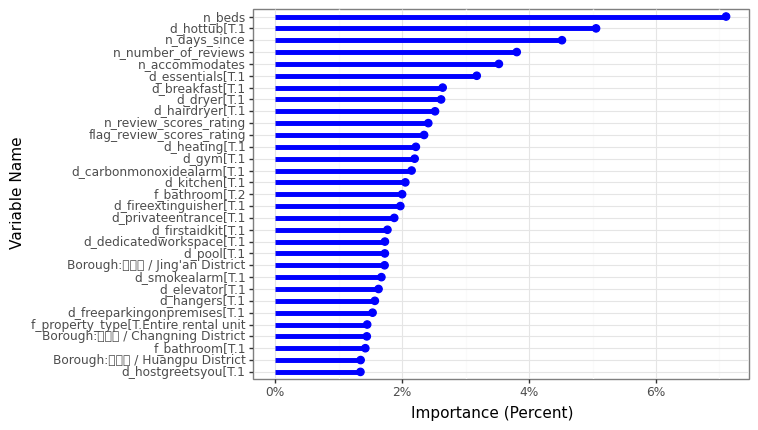

<ggplot: (8773054837357)>

In [84]:
cutoff = 0.013

color_palette = ["blue"]

rf_model_var_imp_plot = (
    ggplot(
        rf_model_var_imp_df.loc[lambda x: x.imp > cutoff],
        aes(x="reorder(varname, imp)", y="imp_percentage"),
    )
    + geom_point(color=color_palette[0], size=2.5)
    + geom_segment(
        aes(x="varname", xend="varname", y=0, yend="imp_percentage"),
        color=color_palette[0],
        size=2,
    )
    + ylab("Importance (Percent)")
    + xlab("Variable Name")
    + coord_flip()
    + scale_y_continuous(labels=percent_format())
    + theme_bw()
)
rf_model_var_imp_plot

2. ***full variable importance plot, top 10 only***

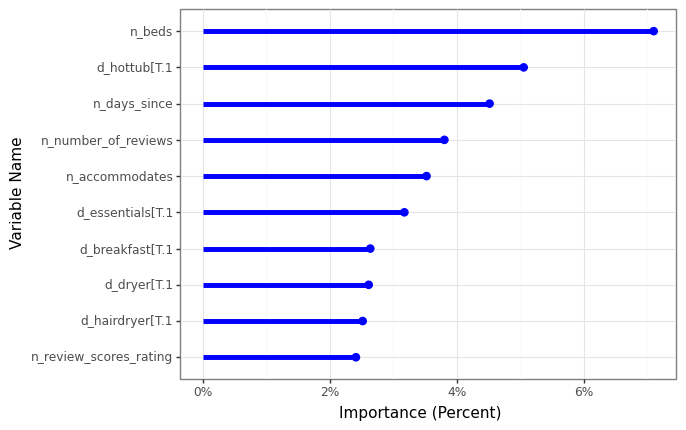

<ggplot: (8772999866393)>

In [85]:
(
    ggplot(
        rf_model_var_imp_df.iloc[:10, :],
        aes(x="reorder(varname, imp)", y="imp_percentage"),
    )
    + geom_point(color=color_palette[0], size=2.5)
    + geom_segment(
        aes(x="varname", xend="varname", y=0, yend="imp_percentage"),
        color=color_palette[0],
        size=2,
    )
    + ylab("Importance (Percent)")
    + xlab("Variable Name")
    + coord_flip()
    + scale_y_continuous(labels=percent_format())
    + theme_bw()
)

3. ***grouped variable importance - keep binaries created off factors together***

In [86]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

In [87]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

rf_best_pipeline = Pipeline(
    [
        ("preprocess", preprocessing),
        ("regressor", rf_model.best_estimator_),  # put best model to pipeline
    ]
)

In [88]:
rf_best_pipeline.fit(data_train[predictors_2], data_train.price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_bathroom',
                                                   'f_neighbourhood_cleansed']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates', 'n_beds',
                                                   'n_days_since',
                                                   'n_number_of_reviews',
                                                   'flag_n_number_of_reviews',
                                                   'n_review_scores_rating',
                                                   'flag_review_scores_rating',
                                                   'd_airconditioni...
       

Permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set.

In [89]:
result = permutation_importance(
    rf_best_pipeline,
    data_train[predictors_2],
    data_train.price,
    n_repeats=10,
    random_state=45,
    n_jobs=-1,
)

[CV 4/5; 24/24] START max_depth=10, n_estimators=450............................
[CV 4/5; 24/24] END max_depth=10, n_estimators=450;, score=-2277.289 total time=   2.0s
[CV 2/5; 22/24] START max_depth=10, n_estimators=350............................
[CV 2/5; 22/24] END max_depth=10, n_estimators=350;, score=-3436.528 total time=   2.2s
[CV 2/5; 24/24] START max_depth=10, n_estimators=450............................
[CV 2/5; 24/24] END max_depth=10, n_estimators=450;, score=-3406.047 total time=   2.5s
[CV 2/5; 23/24] START max_depth=10, n_estimators=400............................
[CV 2/5; 23/24] END max_depth=10, n_estimators=400;, score=-3416.523 total time=   2.4s
[CV 3/5; 21/24] START max_depth=10, n_estimators=300............................
[CV 3/5; 21/24] END max_depth=10, n_estimators=300;, score=-2376.526 total time=   1.9s
[CV 4/5; 23/24] START max_depth=10, n_estimators=400............................
[CV 4/5; 23/24] END max_depth=10, n_estimators=400;, score=-2310.486 total

In [90]:
grouped = [
    "f_property_type",
    "f_bathroom",
    "n_days_since",
    "n_accommodates",
    "n_beds",
    "f_neighbourhood_cleansed",
]
grouped_imp = (
    pd.DataFrame(result.importances_mean, data_train[predictors_2].columns)
    .loc[grouped]
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
    .sort_values(by=["imp"], ascending=False)
)

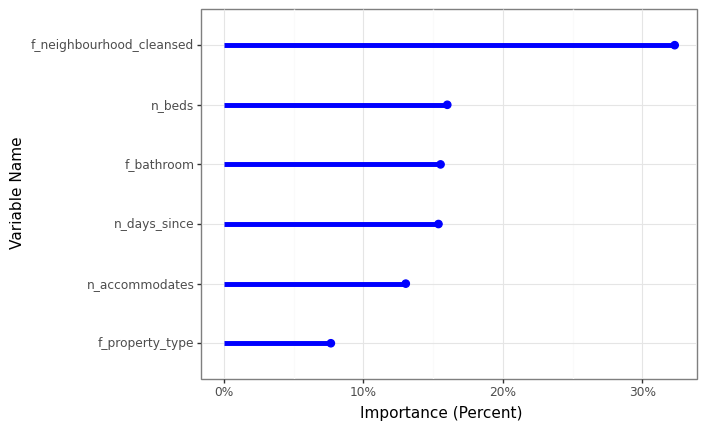

<ggplot: (8773055236994)>

In [91]:
(
    ggplot(
        grouped_imp,
        aes(x="reorder(varname, imp)", y="imp_percentage"),
    )
    + geom_point(color=color_palette[0], size=2.5)
    + geom_segment(
        aes(x="varname", xend="varname", y=0, yend="imp_percentage"),
        color=color_palette[0],
        size=2,
    )
    + ylab("Importance (Percent)")
    + xlab("Variable Name")
    + coord_flip()
    + scale_y_continuous(labels=percent_format())
    + theme_bw()
)

### Partial Dependence Plots

Do this on holdout set!

Partial Dependence Plots show how average y differs for different values of x when all the other x values are the same.

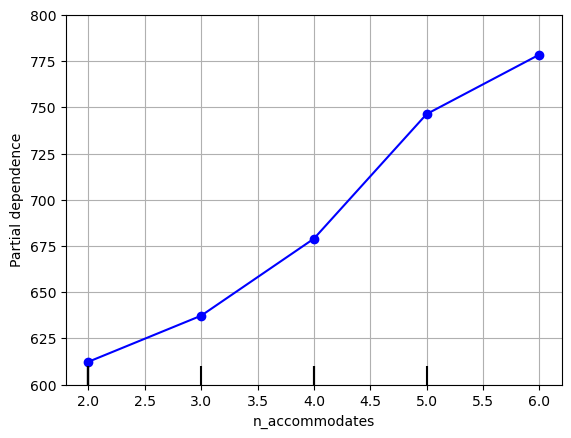

In [92]:
plot_partial_dependence(
    rf_best_pipeline,
    data_holdout[predictors_2],
    ["n_accommodates"],
    feature_names=data_holdout[predictors_2].columns,
    line_kw={"marker": "o", "color": color_palette[0]},
)
plt.grid()
plt.ylim(600, 800)
plt.show()

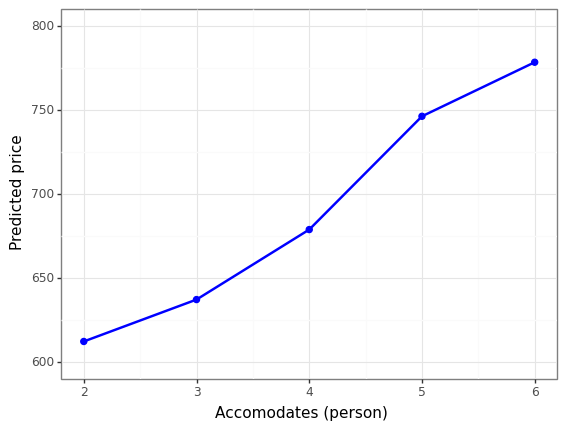

<ggplot: (8773017585297)>

In [93]:
# replicate the figure with plotnine
accom_pdp = partial_dependence(
    rf_best_pipeline, data_holdout[predictors_2], ["n_accommodates"], kind="average"
)

accom_pdp = (
    pd.DataFrame(accom_pdp["average"], columns=accom_pdp["values"][0].tolist())
    .T.reset_index()
    .rename({0: "Predicted price", "index": "Accomodates (person)"}, axis=1)
)

(
    ggplot(accom_pdp, aes(x="Accomodates (person)", y="Predicted price"))
    + geom_point(color=color_palette[0], size=2)
    + geom_line(color=color_palette[0], size=1)
    + scale_y_continuous(limits=[600, 800], breaks=np.arange(600, 810, 50))
    + scale_x_continuous(breaks=range(1, 8))
    + theme_bw()
)

Partial Dependence Plots can also be used to study the heterogeneity if the predictor is category variable.

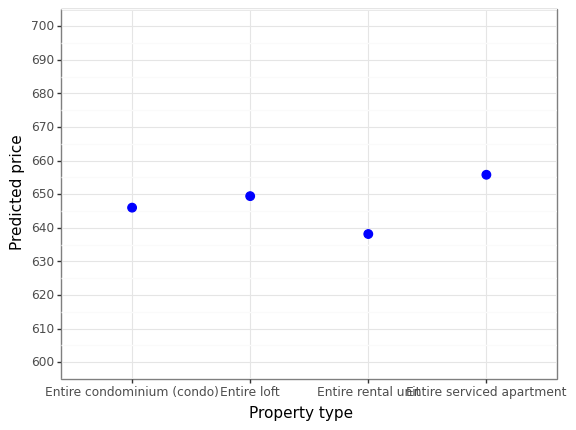

<ggplot: (8773017586210)>

In [94]:
protype_pdp = partial_dependence(
    rf_best_pipeline, data_holdout[predictors_2], ["f_property_type"], kind="average"
)

protype_pdp = (
    pd.DataFrame(protype_pdp["average"], columns=protype_pdp["values"][0].tolist())
    .T.reset_index()
    .rename({0: "Predicted price", "index": "Property type"}, axis=1)
)

(
    ggplot(protype_pdp, aes(x="Property type", y="Predicted price"))
    + geom_point(color=color_palette[0], size=3)
    + scale_y_continuous(limits=[600, 700], breaks=np.arange(600, 710, 10))
    + theme(axis_text_x=element_text(size=6, angle=45))
    + theme_bw()
)

### Subsample performance: RMSE / mean(y) 

NOTE we also do this on the holdout set.

In [95]:
data_holdout_w_prediction = data_holdout.assign(
    predicted_price=rf_best_pipeline.predict(data_holdout[predictors_2])
)

create nice summary table of heterogeneity

In [96]:
def calculate_rmse(groupby_obj):
    return (
        groupby_obj.apply(
            lambda x: mean_squared_error(x.predicted_price, x.price, squared=False),
        )
        .to_frame(name="rmse")
        .assign(mean_price=groupby_obj.apply(lambda x: np.mean(x.price)).values)
        .assign(rmse_norm=lambda x: x.rmse / x.mean_price)
        .round(2)
    )

In [97]:
# cheaper or more expensive flats - not used in book
grouped_object = data_holdout_w_prediction.assign(
    is_low_size=lambda x: np.where(x.n_accommodates <= 3, "small apt", "large apt")
).groupby("is_low_size")
accom_subset = calculate_rmse(grouped_object)

In [98]:
grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.f_property_type.isin(["Entire rental unit",
                                      "Entire condominium (condo)",
                                      "Entire loft",
                                      "Entire serviced apartment"])
].groupby("f_property_type")
proptype_subset = calculate_rmse(grouped_object)

In [99]:
all_holdout = (
    pd.DataFrame(
        [
            mean_squared_error(
                data_holdout_w_prediction.price,
                data_holdout_w_prediction.predicted_price,
                squared=False,
            ),
            data_holdout_w_prediction.price.mean(),
        ],
        index=["rmse", "mean_price"],
    )
    .T.assign(rmse_norm=lambda x: x.rmse / x.mean_price)
    .round(2)
)
all_holdout.index = ["All"]

In [100]:
type_rows = pd.DataFrame(
    None,
    index=["Apartment size", "Type"],
    columns=["rmse", "mean_price", "rmse_norm"],
).fillna("")

In [101]:
pd.concat(
    [
        type_rows.iloc[[0]],
        accom_subset,
        type_rows.iloc[[1]],
        proptype_subset,
        all_holdout,
    ]
)

,rmse,mean_price,rmse_norm
Apartment size,,,
large apt,3793.78,934.97,4.06
small apt,1183.06,485.88,2.43
Type,,,
Entire condominium (condo),733.99,479.53,1.53
Entire loft,2136.82,618.01,3.46
Entire rental unit,2827.72,678.52,4.17
Entire serviced apartment,1779.85,686.03,2.59
All,2445.64,644.24,3.8


This diagnostic work concludes that price prediction is better for small condominiums than for large condominiums, and among the different property types, the Entire condominium has the best price prediction.